In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json, pickle
import os
from tensorflow.keras import layers
import time
import matplotlib.pylab as plt
from PIL import Image

Matplotlib created a temporary config/cache directory at /tmp/pbs.3765242.pbsha.ib.sockeye/matplotlib-ufjsy_y7 because the default path (/home/mkhademi/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
nasnet = tf.keras.models.load_model('/scratch/st-ipor-1/mkhademi/image_data/NASNetlarge.h5')
img_rows, img_cols, channels = 56, 56, 3
data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
output_dir = '/scratch/st-ipor-1/mkhademi/'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
sub = subjs[0]  
bold_imgnames = []
f = open(data_dir + sub + '_imgnames.txt', 'r')
bold_imagenet = []
for imgname in f:
    bold_imgnames.append(imgname[:-1])
    if imgname[0]  == 'n' and (imgname[1] == '0' or imgname[1] == '1'):
        bold_imagenet.append(imgname[:9])
f.close()
bold_imagenet = set(bold_imagenet)

2022-06-05 11:37:01.321741: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-05 11:37:01.375373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-05 11:37:01.431651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-05 11:37:01.966016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-05 11:37:02.245399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-05 11:37:02.813215: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [3]:
batch_size = 10
filename = output_dir + 'image_data/' + sub + 'bold5000_recons.tfrecords'
dataset=tf.data.TFRecordDataset(filenames =[filename]).batch(batch_size).shuffle(buffer_size=100)
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'image': tf.io.FixedLenFeature(shape=(img_rows, img_cols, channels),dtype=tf.float32),
        })
    return example['x'], example['image']
dataset = dataset.map(tf_parse)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    #tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.4),
    # tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(7*7*32),
    tf.keras.layers.Reshape((7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, 
                                     activation='tanh')
    ])
model.summary()
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[tf.keras.metrics.MeanSquaredError()],
)
model.fit(dataset, epochs=200)
model.save(output_dir + 'image_data/recons_model')
del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten (Flatten)            (None, 26928)             0         
_________________________________________________________________
dropout (Dropout)            (None, 26928)             0

2022-06-05 11:37:26.891558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-05 11:37:28.571463: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


526/526 [==============================] - 21s 40ms/step - loss: 0.2945 - mean_squared_error: 0.2945
Epoch 2/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2899 - mean_squared_error: 0.2899
Epoch 3/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2890 - mean_squared_error: 0.2890
Epoch 4/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2875 - mean_squared_error: 0.2875
Epoch 5/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2852 - mean_squared_error: 0.2852
Epoch 6/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2821 - mean_squared_error: 0.2821
Epoch 7/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2781 - mean_squared_error: 0.2781
Epoch 8/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2727 - mean_squared_error: 0.2727
Epoch 9/200
526/526 [==============================] - 19s 36ms/step - loss: 0.2656 - mean_squared_error: 0.

2022-06-05 12:43:27.095818: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /scratch/st-ipor-1/mkhademi/image_data/recons_model/assets


In [4]:
img_path = data_dir + '/image_data/ILSVRC/Data/CLS-LOC/train/'
categories = os.listdir(img_path)
def create_tf_records():
    filename = output_dir + 'image_data/bold_recons.tfrecords'
    writer_recons = tf.io.TFRecordWriter(filename)
    st_time = time.time()
    for cat in categories:
        tmp = img_path + '/' + cat + '/'
        names = os.listdir(tmp)
        for name in names:
            image = tf.keras.preprocessing.image.load_img(tmp + name, target_size=(331, 331))
            image = tf.keras.preprocessing.image.img_to_array(image)
            x = tf.reshape(tf.cast(tf.image.resize(image, (int(img_rows), int(img_cols))),
                                  tf.float32) / 127.5 - 1, (1, img_rows, img_cols, channels))
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = tf.keras.applications.nasnet.preprocess_input(image)  
            yhat = nasnet.predict(image)
            example = tf.train.Example(features=tf.train.Features(feature={
                    'x': tf.train.Feature(float_list=tf.train.FloatList(value=yhat[0])),
                    'y': tf.train.Feature(float_list=tf.train.FloatList(value=np.reshape(x,(-1))))
                    }))
            writer_recons.write(example.SerializeToString())
    writer_recons.close()
    print(time.time()- st_time)
    return
#create_tf_records()

[[[-0.2972173  -0.35917512 -0.51153344]
  [-0.3544046  -0.4193536  -0.608323  ]
  [-0.45850843 -0.5066693  -0.6824142 ]
  ...
  [-0.37878188 -0.35153675 -0.5511474 ]
  [-0.2538161  -0.2211473  -0.4199175 ]
  [-0.16097476 -0.13906415 -0.29501918]]

 [[-0.38026497 -0.454314   -0.6359652 ]
  [-0.4100559  -0.48032948 -0.72230476]
  [-0.5029781  -0.5514349  -0.76389706]
  ...
  [-0.49811518 -0.4291929  -0.6820674 ]
  [-0.3208021  -0.24787942 -0.506198  ]
  [-0.19229597 -0.14686066 -0.3715233 ]]

 [[-0.4842869  -0.54875994 -0.7116635 ]
  [-0.53110206 -0.59423304 -0.77388775]
  [-0.5616989  -0.6146239  -0.795951  ]
  ...
  [-0.52912223 -0.46542975 -0.6900078 ]
  [-0.38148212 -0.33149928 -0.5558007 ]
  [-0.27075452 -0.25132716 -0.44255283]]

 ...

 [[ 0.13953313  0.15172866 -0.02099847]
  [ 0.10874504  0.14914519 -0.07778126]
  [ 0.07232158  0.09724925 -0.13097437]
  ...
  [ 0.08507015  0.08886464 -0.17695184]
  [ 0.00156378  0.02744427 -0.2922618 ]
  [-0.06758846 -0.0176411  -0.352549  ]]

 [

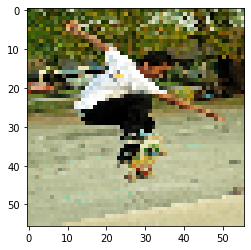

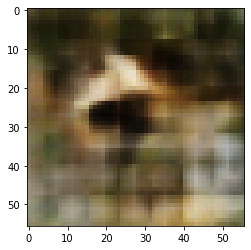

[[[ 1.83763146e-01  1.12499125e-01  2.74155419e-02]
  [ 2.20977768e-01  1.28856942e-01  2.16511469e-02]
  [ 2.33578846e-01  1.58484370e-01  4.00471799e-02]
  ...
  [ 7.03952834e-02 -2.20259968e-02 -1.57864049e-01]
  [ 7.18842819e-02 -1.29633797e-02 -1.42346352e-01]
  [ 6.60604909e-02 -1.49770267e-02 -1.24024354e-01]]

 [[ 2.59788990e-01  1.60156876e-01  5.32581806e-02]
  [ 2.98757166e-01  1.63450494e-01  8.78033601e-03]
  [ 2.71228135e-01  1.54421672e-01 -4.03106818e-03]
  ...
  [ 1.00581340e-01 -3.32136154e-02 -2.14166015e-01]
  [ 1.06157400e-01 -2.74751764e-02 -1.84128568e-01]
  [ 9.09466594e-02 -4.12261486e-02 -1.92663625e-01]]

 [[ 2.59719968e-01  1.32318586e-01  3.76507611e-04]
  [ 2.75754184e-01  9.40036178e-02 -6.31295890e-02]
  [ 2.47279614e-01  8.68159905e-02 -1.01098076e-01]
  ...
  [ 4.49658744e-02 -1.10177115e-01 -2.98357725e-01]
  [ 4.71085943e-02 -1.12289861e-01 -3.02622855e-01]
  [ 3.63268815e-02 -1.32634476e-01 -3.07574749e-01]]

 ...

 [[-2.42683262e-01 -2.97311306e-01

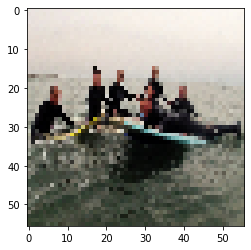

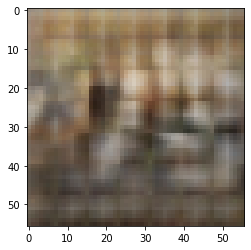

[[[-0.05094581 -0.14811955 -0.24250713]
  [-0.04678819 -0.17268251 -0.29393134]
  [-0.08788873 -0.22141428 -0.3517269 ]
  ...
  [-0.06593805 -0.08917309 -0.12338439]
  [-0.03203891 -0.05499378 -0.09648684]
  [ 0.01316015 -0.01240511 -0.05953225]]

 [[-0.0681046  -0.20893972 -0.32542318]
  [-0.03760868 -0.22569863 -0.3930696 ]
  [-0.07281241 -0.270239   -0.4339889 ]
  ...
  [-0.06074188 -0.09082415 -0.12119395]
  [-0.01878434 -0.05863488 -0.08875017]
  [ 0.02090055 -0.02395849 -0.07999558]]

 [[-0.11377645 -0.27655607 -0.4059534 ]
  [-0.11005061 -0.3296753  -0.47187713]
  [-0.12754685 -0.3518699  -0.50940263]
  ...
  [-0.08500437 -0.14520645 -0.16431922]
  [-0.04861519 -0.11640146 -0.17021412]
  [-0.02900525 -0.10019453 -0.18517572]]

 ...

 [[-0.09219016 -0.28037208 -0.43276805]
  [-0.00262767 -0.27755496 -0.47682005]
  [ 0.00258296 -0.26936135 -0.48043668]
  ...
  [-0.24022876 -0.41088483 -0.586195  ]
  [-0.2495371  -0.40934753 -0.6007855 ]
  [-0.2651016  -0.40146697 -0.59852326]]

 [

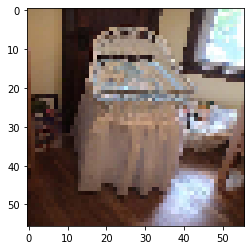

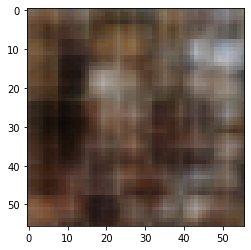

[[[ 0.10880821 -0.02517547 -0.18313023]
  [ 0.1726561  -0.01002433 -0.23094916]
  [ 0.16355413 -0.01769949 -0.263321  ]
  ...
  [-0.09531781 -0.29681844 -0.52957886]
  [-0.17883411 -0.32819718 -0.520604  ]
  [-0.21470602 -0.31797224 -0.46870738]]

 [[ 0.15513791 -0.03902227 -0.25346726]
  [ 0.26033956 -0.01268069 -0.33017737]
  [ 0.23877607 -0.03210306 -0.3695688 ]
  ...
  [-0.12532407 -0.40749758 -0.6816735 ]
  [-0.19122857 -0.40113977 -0.62661105]
  [-0.20799133 -0.35835412 -0.55607533]]

 [[ 0.12759918 -0.09730534 -0.33524054]
  [ 0.19360036 -0.12325856 -0.4120853 ]
  [ 0.18723428 -0.1339296  -0.45585456]
  ...
  [-0.18750483 -0.45032746 -0.68330944]
  [-0.23211616 -0.4483814  -0.6577209 ]
  [-0.26013932 -0.43857348 -0.6261696 ]]

 ...

 [[-0.17223185 -0.3591969  -0.53749293]
  [-0.17415601 -0.43213737 -0.6510136 ]
  [-0.20796709 -0.4653883  -0.68002594]
  ...
  [-0.6035925  -0.67764366 -0.75030535]
  [-0.65006953 -0.72353184 -0.809905  ]
  [-0.67782867 -0.738353   -0.8362061 ]]

 [

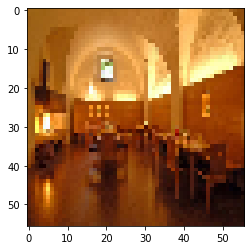

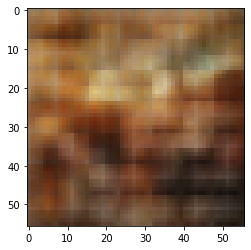

[[[ 0.26196098  0.20383328  0.13055897]
  [ 0.30516285  0.23311526  0.14150377]
  [ 0.37366048  0.32918972  0.22854865]
  ...
  [-0.07659883 -0.16738583 -0.32050282]
  [-0.06368591 -0.16088587 -0.31078097]
  [-0.02753238 -0.12725277 -0.26011598]]

 [[ 0.3579207   0.28019577  0.19286673]
  [ 0.3912187   0.2862534   0.15649132]
  [ 0.41800585  0.3467772   0.21074483]
  ...
  [-0.08144321 -0.20729356 -0.40408826]
  [-0.05851504 -0.20108362 -0.3792556 ]
  [-0.01068411 -0.16469727 -0.34302336]]

 [[ 0.3675086   0.2608897   0.14013037]
  [ 0.38409725  0.23284672  0.08935493]
  [ 0.39529836  0.28069058  0.11133691]
  ...
  [-0.07279465 -0.24447757 -0.44147766]
  [-0.07466248 -0.25638953 -0.4535395 ]
  [-0.07634079 -0.2663933  -0.44885382]]

 ...

 [[ 0.10192242 -0.01587839 -0.09524435]
  [-0.01372033 -0.18246858 -0.27544957]
  [-0.05406862 -0.20796727 -0.32283208]
  ...
  [ 0.19571051  0.06692401 -0.10213728]
  [ 0.14183222  0.01624295 -0.21506265]
  [ 0.08575808 -0.03184644 -0.29669857]]

 [

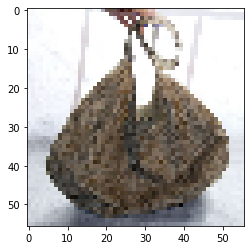

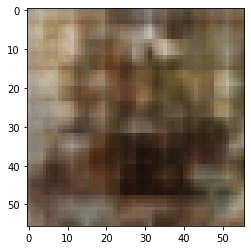

[[[-0.15636422 -0.20038031 -0.2848283 ]
  [-0.18677002 -0.23323265 -0.33581313]
  [-0.2573896  -0.29161498 -0.38644856]
  ...
  [-0.4837999  -0.5329057  -0.6693317 ]
  [-0.51972365 -0.55627644 -0.67480546]
  [-0.5027113  -0.5321468  -0.6408316 ]]

 [[-0.2108685  -0.27115202 -0.37443572]
  [-0.23059335 -0.28792766 -0.4341535 ]
  [-0.29649094 -0.33423612 -0.4516865 ]
  ...
  [-0.5693905  -0.6189738  -0.77278745]
  [-0.57421356 -0.6122377  -0.7439716 ]
  [-0.5422201  -0.57436365 -0.7052421 ]]

 [[-0.26661065 -0.3353471  -0.4303437 ]
  [-0.30377564 -0.3821978  -0.4840863 ]
  [-0.33425304 -0.40458533 -0.51579106]
  ...
  [-0.6088867  -0.6627935  -0.784839  ]
  [-0.6099503  -0.6535088  -0.77074385]
  [-0.6100632  -0.6472024  -0.7612978 ]]

 ...

 [[-0.15372548 -0.21292278 -0.34989384]
  [-0.18523765 -0.24670914 -0.42756683]
  [-0.19456536 -0.25204554 -0.4496124 ]
  ...
  [-0.34874538 -0.4086609  -0.6592051 ]
  [-0.34553814 -0.43655634 -0.6661685 ]
  [-0.3579928  -0.4601484  -0.66340375]]

 [

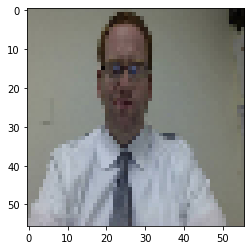

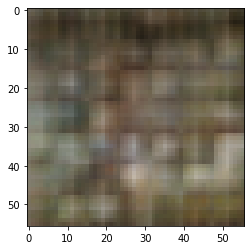

[[[ 1.7347854e-01  1.8229921e-01  1.8400189e-01]
  [ 1.7333815e-01  1.9639890e-01  2.1203932e-01]
  [ 1.9498311e-01  2.3211595e-01  2.4161159e-01]
  ...
  [-1.8984474e-01 -7.3325760e-03  1.7933406e-01]
  [-1.2462037e-01 -1.0010193e-02  9.5787778e-02]
  [-4.0828411e-02  5.3261393e-03  4.6242069e-02]]

 [[ 2.2361530e-01  2.3592721e-01  2.5596121e-01]
  [ 1.8096423e-01  2.1401504e-01  2.4080101e-01]
  [ 1.9536318e-01  2.3801026e-01  2.5951651e-01]
  ...
  [-2.6361394e-01  1.7807864e-02  3.0396554e-01]
  [-1.4944938e-01  4.1972673e-03  1.7570314e-01]
  [-5.8943450e-02 -2.1738080e-04  7.1963422e-02]]

 [[ 2.5113297e-01  2.2878374e-01  2.1263155e-01]
  [ 2.0811427e-01  1.8104483e-01  1.8730833e-01]
  [ 1.8095142e-01  1.9035271e-01  1.8509795e-01]
  ...
  [-2.4297306e-01 -5.3966194e-02  1.8922631e-01]
  [-1.7993107e-01 -6.5616429e-02  6.1534602e-02]
  [-1.3906518e-01 -8.4094837e-02 -3.0500133e-02]]

 ...

 [[-5.9435844e-01 -6.1800408e-01 -6.4357209e-01]
  [-6.6509426e-01 -6.7616355e-01 -6.903

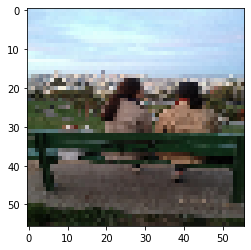

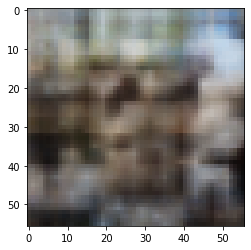

[[[ 0.04821185 -0.00117017 -0.08921964]
  [ 0.05770258 -0.00618817 -0.11349425]
  [ 0.06183858 -0.01654951 -0.13464671]
  ...
  [ 0.3696567   0.35687137  0.31089   ]
  [ 0.3730667   0.34726483  0.29576457]
  [ 0.34983337  0.324362    0.28195587]]

 [[ 0.05774734 -0.01253305 -0.12351109]
  [ 0.04610372 -0.04218079 -0.19588417]
  [ 0.08200239 -0.02814513 -0.17538537]
  ...
  [ 0.39131638  0.3570547   0.2965751 ]
  [ 0.4107516   0.3608803   0.29528394]
  [ 0.42016646  0.36676168  0.30529428]]

 [[ 0.10435073  0.01684134 -0.10182818]
  [ 0.07858191 -0.03779604 -0.17864412]
  [ 0.10545573 -0.01679046 -0.15784301]
  ...
  [ 0.39678714  0.35572368  0.29204598]
  [ 0.40433702  0.35963216  0.27697098]
  [ 0.3873939   0.3418206   0.26284283]]

 ...

 [[ 0.10278355 -0.00256228 -0.1075503 ]
  [ 0.17551737  0.03211628 -0.11003143]
  [ 0.10171805 -0.0237189  -0.14335728]
  ...
  [ 0.6024263   0.5398848   0.4617294 ]
  [ 0.6016264   0.5369351   0.44390675]
  [ 0.641921    0.58453447  0.50317746]]

 [

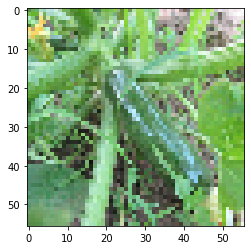

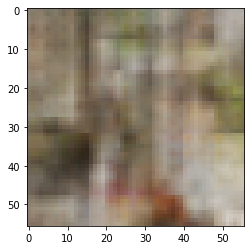

[[[ 0.14814422  0.11153739  0.01620327]
  [ 0.18084945  0.13713443  0.00355809]
  [ 0.16300699  0.13997059  0.01621437]
  ...
  [-0.23962946 -0.32578763 -0.41775382]
  [-0.22571063 -0.30153447 -0.3996851 ]
  [-0.21414818 -0.26451132 -0.34857428]]

 [[ 0.19025119  0.1370217   0.00530904]
  [ 0.20811054  0.1438734  -0.05955841]
  [ 0.16605614  0.13580479 -0.04278347]
  ...
  [-0.31057575 -0.4206612  -0.5269368 ]
  [-0.26076186 -0.35760581 -0.4631955 ]
  [-0.2276606  -0.3005606  -0.40327367]]

 [[ 0.18024312  0.12095696 -0.00692748]
  [ 0.15132391  0.07545566 -0.0909769 ]
  [ 0.08571285  0.0299725  -0.12447458]
  ...
  [-0.35888    -0.45882702 -0.5374775 ]
  [-0.29427418 -0.39193356 -0.4788288 ]
  [-0.24666329 -0.33047262 -0.42624992]]

 ...

 [[-0.56918555 -0.6299398  -0.69189036]
  [-0.6741642  -0.72648644 -0.78793406]
  [-0.6771835  -0.74168813 -0.7913333 ]
  ...
  [-0.03002246 -0.07755078 -0.12919147]
  [-0.02701724 -0.08617051 -0.18006599]
  [-0.05063894 -0.11305826 -0.23340854]]

 [

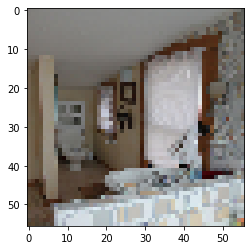

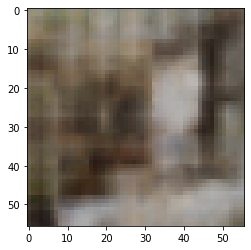

[[[-0.34117845 -0.40286958 -0.47492632]
  [-0.41383347 -0.47872537 -0.5541023 ]
  [-0.49524495 -0.56541157 -0.6274011 ]
  ...
  [-0.0486959  -0.06462942 -0.19159447]
  [-0.10388989 -0.10490568 -0.23566858]
  [-0.16168843 -0.15080142 -0.2603052 ]]

 [[-0.4554349  -0.53438556 -0.60579276]
  [-0.5163357  -0.5908566  -0.68094957]
  [-0.57503843 -0.6556511  -0.71481436]
  ...
  [-0.08330576 -0.0947933  -0.2789963 ]
  [-0.11705049 -0.10316037 -0.27746493]
  [-0.1672197  -0.14208108 -0.28909332]]

 [[-0.51049125 -0.5904255  -0.6458074 ]
  [-0.58113503 -0.6657959  -0.71298563]
  [-0.6268776  -0.7107105  -0.7531204 ]
  ...
  [-0.11897966 -0.13818572 -0.270681  ]
  [-0.15708368 -0.17499958 -0.30433518]
  [-0.2156173  -0.22399144 -0.34641245]]

 ...

 [[-0.20976384 -0.28805372 -0.35968563]
  [-0.20290534 -0.3102246  -0.38611713]
  [-0.27698648 -0.38244364 -0.47080997]
  ...
  [ 0.01020343  0.004136   -0.01076187]
  [-0.02189695 -0.04143939 -0.0677456 ]
  [-0.0641378  -0.08949522 -0.12916581]]

 [

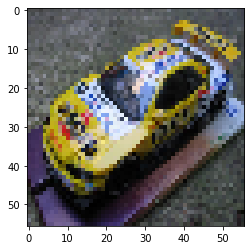

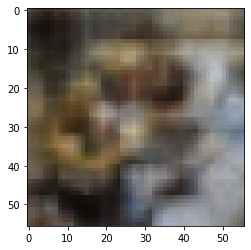

[[[-0.11250339 -0.18326248 -0.29577196]
  [-0.136212   -0.22024056 -0.36073226]
  [-0.19328344 -0.2773953  -0.41961038]
  ...
  [-0.18140092 -0.29082713 -0.49562386]
  [-0.19724101 -0.2789029  -0.46560845]
  [-0.17185242 -0.22836581 -0.38458124]]

 [[-0.15121494 -0.24997899 -0.38988775]
  [-0.1556342  -0.2694957  -0.46520248]
  [-0.20909998 -0.32076076 -0.502113  ]
  ...
  [-0.18990263 -0.33795702 -0.6029191 ]
  [-0.19154407 -0.30147913 -0.53513336]
  [-0.15427318 -0.23320445 -0.44556457]]

 [[-0.18877885 -0.30656475 -0.44658315]
  [-0.21672319 -0.36573353 -0.52181613]
  [-0.2424003  -0.39512894 -0.5620506 ]
  ...
  [-0.22032043 -0.34408274 -0.56768525]
  [-0.22010545 -0.33011198 -0.53529465]
  [-0.21047854 -0.30860436 -0.49698848]]

 ...

 [[-0.04164741 -0.13126044 -0.31166676]
  [-0.14116576 -0.24813944 -0.47107232]
  [-0.17683798 -0.27131802 -0.5008472 ]
  ...
  [-0.12199974 -0.22010832 -0.3913465 ]
  [-0.11629756 -0.24955858 -0.4933514 ]
  [-0.16484854 -0.30693886 -0.57737064]]

 [

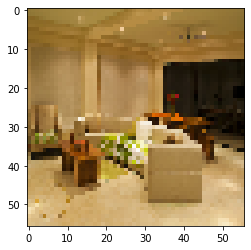

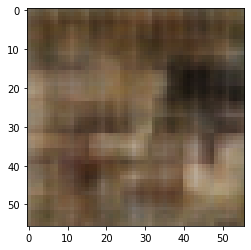

[[[ 0.16843656  0.19625588  0.2121718 ]
  [ 0.17434585  0.22628446  0.26424065]
  [ 0.21838558  0.30063358  0.3483986 ]
  ...
  [ 0.36709708  0.4606491   0.5514524 ]
  [ 0.32115898  0.41990703  0.5015466 ]
  [ 0.23859712  0.3244126   0.39188322]]

 [[ 0.20506108  0.24680547  0.28476432]
  [ 0.16200389  0.2399882   0.29732114]
  [ 0.18541215  0.3028222   0.38199344]
  ...
  [ 0.40822566  0.5281335   0.6427728 ]
  [ 0.37035954  0.4839191   0.5872545 ]
  [ 0.28585508  0.39489013  0.4857716 ]]

 [[ 0.23097073  0.24949786  0.25867653]
  [ 0.19933486  0.23651296  0.2711539 ]
  [ 0.18441452  0.26576635  0.31650174]
  ...
  [ 0.3912383   0.51390153  0.60923827]
  [ 0.36089012  0.46860573  0.55586934]
  [ 0.27965903  0.3811568   0.47286594]]

 ...

 [[ 0.11814127  0.1774021   0.19628975]
  [ 0.1578806   0.24223119  0.28991863]
  [ 0.15425748  0.21807115  0.25471863]
  ...
  [-0.50759125 -0.567857   -0.7905611 ]
  [-0.5393927  -0.584531   -0.8036179 ]
  [-0.5217918  -0.55576384 -0.7745187 ]]

 [

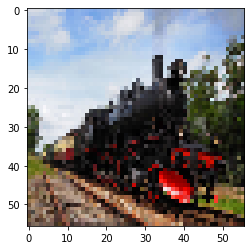

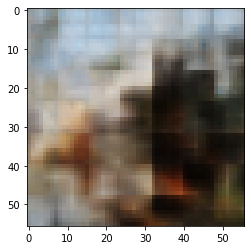

[[[ 0.03689121  0.01870045 -0.03322318]
  [ 0.03464647  0.02389061 -0.02918653]
  [ 0.01179811  0.01256063 -0.04269382]
  ...
  [-0.13297312 -0.11465336 -0.12098501]
  [-0.1051892  -0.09169036 -0.11467573]
  [-0.06607515 -0.06311827 -0.08847053]]

 [[ 0.06559103  0.04564826 -0.01301401]
  [ 0.06742314  0.06160617 -0.01309341]
  [ 0.02061397  0.0247424  -0.03800412]
  ...
  [-0.16934185 -0.13422179 -0.12857649]
  [-0.11677664 -0.10028601 -0.10665722]
  [-0.06765046 -0.06636591 -0.09058032]]

 [[ 0.06181803  0.02095741 -0.05124086]
  [ 0.04614602  0.00276198 -0.06634083]
  [-0.00344547 -0.03258346 -0.11179905]
  ...
  [-0.1744962  -0.1678548  -0.16780609]
  [-0.1375894  -0.14506762 -0.17505172]
  [-0.11343367 -0.13410538 -0.18523568]]

 ...

 [[ 0.08939822  0.05266082 -0.03808163]
  [ 0.02191879 -0.01477871 -0.11708558]
  [ 0.01216839 -0.02621596 -0.14066343]
  ...
  [-0.28307387 -0.33530033 -0.48173103]
  [-0.21392639 -0.27318746 -0.46100855]
  [-0.16164078 -0.21924202 -0.4217072 ]]

 [

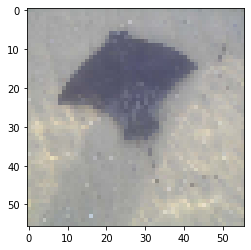

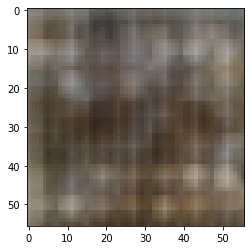

[[[-0.3827401  -0.42658186 -0.509434  ]
  [-0.4652063  -0.50966173 -0.60620594]
  [-0.55370975 -0.5932662  -0.6588796 ]
  ...
  [-0.5477599  -0.60539496 -0.6753884 ]
  [-0.6308443  -0.6877067  -0.7434932 ]
  [-0.6565703  -0.7052176  -0.75485003]]

 [[-0.4580255  -0.51502967 -0.61067176]
  [-0.50698626 -0.5583472  -0.68629646]
  [-0.5889702  -0.6321833  -0.70094967]
  ...
  [-0.5659648  -0.6467098  -0.71278286]
  [-0.63111925 -0.708882   -0.75656956]
  [-0.67647785 -0.7406273  -0.7811856 ]]

 [[-0.5331796  -0.5795803  -0.65146565]
  [-0.5819907  -0.6237619  -0.6922441 ]
  [-0.6304228  -0.67766535 -0.7337748 ]
  ...
  [-0.5811671  -0.6691319  -0.7284892 ]
  [-0.65772843 -0.7380177  -0.785433  ]
  [-0.7444623  -0.80237466 -0.83762103]]

 ...

 [[ 0.39566937  0.23751532  0.13087659]
  [ 0.5277525   0.3142119   0.16832452]
  [ 0.5161785   0.34706768  0.23573744]
  ...
  [ 0.6260771   0.5225914   0.46067336]
  [ 0.5868205   0.45215777  0.37119204]
  [ 0.51169574  0.35904428  0.29144654]]

 [

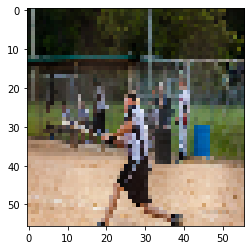

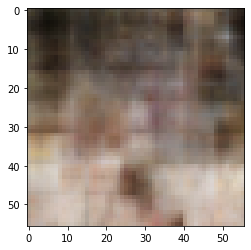

[[[-0.03155993 -0.02617734 -0.02954914]
  [-0.0108108   0.0063609   0.02561467]
  [-0.0432234  -0.02066057 -0.01900466]
  ...
  [ 0.00499974  0.02486453  0.0387673 ]
  [ 0.06424221  0.0989359   0.10934265]
  [ 0.06365383  0.1025498   0.10957871]]

 [[-0.02265517 -0.01440265 -0.00578855]
  [ 0.03213791  0.06216653  0.09342129]
  [ 0.00402645  0.03147335  0.04448334]
  ...
  [-0.02400027  0.00339974  0.01315029]
  [ 0.07891995  0.1215862   0.13579082]
  [ 0.07835605  0.1273762   0.13808005]]

 [[ 0.01097661  0.01557474  0.00783817]
  [ 0.04102254  0.0611356   0.07228568]
  [ 0.02643633  0.04016457  0.03872889]
  ...
  [-0.03410639 -0.01123246 -0.00685527]
  [ 0.03894043  0.07000436  0.08169392]
  [ 0.0338387   0.07693989  0.0966664 ]]

 ...

 [[ 0.25581285  0.20978965  0.20794855]
  [ 0.1304959   0.05643668  0.06411358]
  [ 0.04030751 -0.03093257 -0.01844334]
  ...
  [ 0.29679924  0.3163562   0.36537364]
  [ 0.22819103  0.22229381  0.24438702]
  [ 0.15744253  0.1294867   0.13602962]]

 [

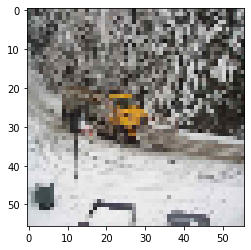

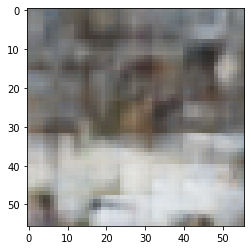

[[[-0.38691813 -0.4409434  -0.4972289 ]
  [-0.4668105  -0.5199162  -0.5721785 ]
  [-0.5345193  -0.59668326 -0.63588506]
  ...
  [-0.4800759  -0.55247784 -0.6599413 ]
  [-0.45315164 -0.5219102  -0.61568224]
  [-0.38130575 -0.44228396 -0.5244179 ]]

 [[-0.48762012 -0.5572357  -0.608168  ]
  [-0.540094   -0.6019081  -0.6647255 ]
  [-0.590842   -0.66471654 -0.69513106]
  ...
  [-0.5710666  -0.65412486 -0.76886654]
  [-0.5084077  -0.5934464  -0.6895896 ]
  [-0.39870006 -0.48409897 -0.5801865 ]]

 [[-0.52956355 -0.60752237 -0.64943874]
  [-0.5816408  -0.6668486  -0.69822896]
  [-0.6091472  -0.70119363 -0.7312434 ]
  ...
  [-0.6023085  -0.68704575 -0.7685914 ]
  [-0.5413945  -0.6294919  -0.7120037 ]
  [-0.4724424  -0.5629994  -0.65137756]]

 ...

 [[-0.36677718 -0.45212984 -0.584014  ]
  [-0.41083536 -0.5050765  -0.6662606 ]
  [-0.45349854 -0.53867626 -0.6858336 ]
  ...
  [-0.4172163  -0.5134639  -0.65019894]
  [-0.35593662 -0.4652499  -0.614244  ]
  [-0.3054478  -0.40404305 -0.5439682 ]]

 [

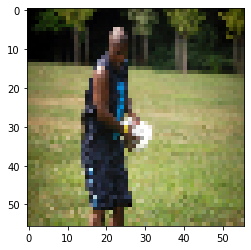

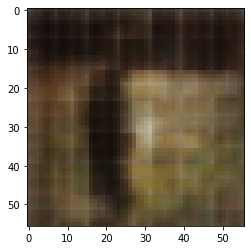

[[[ 7.8087106e-02 -1.1828731e-02 -1.1933139e-01]
  [ 9.5864989e-02 -2.4906259e-02 -1.6971162e-01]
  [ 5.7307031e-02 -5.6742858e-02 -2.1331400e-01]
  ...
  [-2.3847480e-01 -3.3667105e-01 -4.8815930e-01]
  [-2.1977292e-01 -3.0307153e-01 -4.2318335e-01]
  [-1.7895213e-01 -2.5259143e-01 -3.3035612e-01]]

 [[ 1.4208584e-01  1.3189557e-02 -1.2866458e-01]
  [ 1.7978674e-01 -8.5637119e-05 -2.0884615e-01]
  [ 1.2209761e-01 -5.1411640e-02 -2.5885335e-01]
  ...
  [-3.0665261e-01 -4.3173605e-01 -6.1526239e-01]
  [-2.6149288e-01 -3.7594908e-01 -5.0640345e-01]
  [-1.9361348e-01 -3.0539846e-01 -3.9865011e-01]]

 [[ 1.2403929e-01 -2.1398704e-02 -1.8717444e-01]
  [ 1.3530813e-01 -6.6447936e-02 -2.6259953e-01]
  [ 7.5948544e-02 -1.1547180e-01 -3.3165708e-01]
  ...
  [-3.1820425e-01 -4.3112728e-01 -5.9536409e-01]
  [-2.7993947e-01 -3.9921439e-01 -5.3799134e-01]
  [-2.5091654e-01 -3.8182819e-01 -4.9483076e-01]]

 ...

 [[-3.6650273e-01 -3.8140196e-01 -4.1959271e-01]
  [-4.8972863e-01 -4.9709731e-01 -5.245

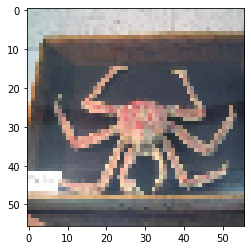

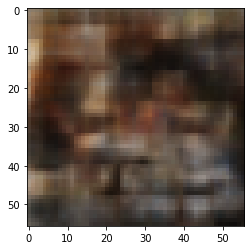

[[[ 0.12155613  0.0885704  -0.00121659]
  [ 0.11040606  0.07230693 -0.04056864]
  [ 0.06205999  0.04427905 -0.077154  ]
  ...
  [-0.21187215 -0.16520916 -0.22602311]
  [-0.17865637 -0.125058   -0.19031541]
  [-0.14619829 -0.1033959  -0.15653656]]

 [[ 0.18196927  0.14069659  0.02660586]
  [ 0.15821975  0.11228114 -0.05168073]
  [ 0.07365704  0.05357669 -0.10432886]
  ...
  [-0.26813048 -0.1788739  -0.25841546]
  [-0.20558563 -0.11634391 -0.1875883 ]
  [-0.1677247  -0.09669711 -0.16314879]]

 [[ 0.16774671  0.1108438  -0.01729112]
  [ 0.11328766  0.04039636 -0.10929506]
  [ 0.02913861 -0.03007199 -0.19992673]
  ...
  [-0.28244868 -0.20703499 -0.27847707]
  [-0.22848499 -0.16434486 -0.24353491]
  [-0.19666795 -0.15205    -0.22545446]]

 ...

 [[-0.35517302 -0.35811192 -0.54575825]
  [-0.44911158 -0.42087442 -0.65440005]
  [-0.48327756 -0.46241578 -0.69103444]
  ...
  [-0.3307763  -0.33640856 -0.62974674]
  [-0.31706145 -0.33102775 -0.62478346]
  [-0.300902   -0.3184418  -0.5919187 ]]

 [

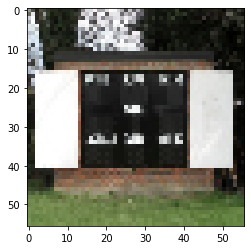

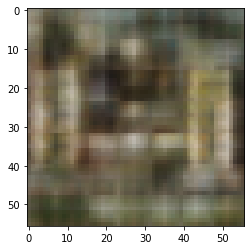

[[[-2.17576444e-01 -2.60689497e-01 -3.93447638e-01]
  [-2.24695534e-01 -2.68877536e-01 -4.50588167e-01]
  [-1.78963661e-01 -2.47238234e-01 -3.92817289e-01]
  ...
  [-2.86046296e-01 -2.92985767e-01 -5.59964657e-01]
  [-3.79305422e-01 -3.90100002e-01 -6.26743078e-01]
  [-4.46008116e-01 -4.58205372e-01 -6.67789340e-01]]

 [[-2.99769849e-01 -3.46028656e-01 -5.17439961e-01]
  [-3.02925527e-01 -3.40010732e-01 -5.90694010e-01]
  [-2.33461127e-01 -3.11619550e-01 -4.94323581e-01]
  ...
  [-3.51479590e-01 -3.47263306e-01 -6.96244955e-01]
  [-4.00996923e-01 -3.91718715e-01 -7.07636118e-01]
  [-4.67647880e-01 -4.63898242e-01 -7.34033108e-01]]

 [[-2.57772088e-01 -3.19527417e-01 -4.75839078e-01]
  [-2.54086971e-01 -3.21488500e-01 -5.19363880e-01]
  [-2.14960650e-01 -3.02187920e-01 -4.61166471e-01]
  ...
  [-3.64992499e-01 -3.48099530e-01 -6.68109417e-01]
  [-3.89949203e-01 -4.03286904e-01 -6.83257103e-01]
  [-4.69172746e-01 -4.80699718e-01 -7.24859953e-01]]

 ...

 [[ 1.21466458e-01  2.73532979e-03

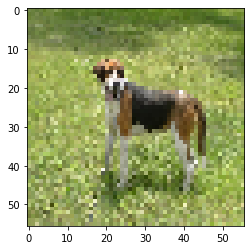

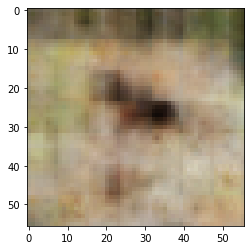

[[[-0.40347102 -0.45038944 -0.5289471 ]
  [-0.5146212  -0.5550182  -0.6323155 ]
  [-0.6135871  -0.65604675 -0.72009337]
  ...
  [ 0.3952248   0.40194598  0.3008412 ]
  [ 0.4085439   0.42874807  0.34240597]
  [ 0.40138516  0.42138344  0.3632471 ]]

 [[-0.4900402  -0.5489378  -0.6275567 ]
  [-0.5806396  -0.62186885 -0.716207  ]
  [-0.662417   -0.7066688  -0.77107465]
  ...
  [ 0.47158727  0.4849055   0.35157552]
  [ 0.4668999   0.4879602   0.38081828]
  [ 0.4514597   0.47106603  0.3827414 ]]

 [[-0.5301171  -0.6024703  -0.6758672 ]
  [-0.61335695 -0.6865618  -0.74922824]
  [-0.66974896 -0.74049675 -0.80209535]
  ...
  [ 0.46117616  0.4687026   0.3186047 ]
  [ 0.45872745  0.47434986  0.34128958]
  [ 0.46794477  0.47862148  0.3844232 ]]

 ...

 [[-0.4872688  -0.57597417 -0.7077676 ]
  [-0.57307494 -0.66108173 -0.8050715 ]
  [-0.59960645 -0.68120915 -0.82902384]
  ...
  [ 0.52718943  0.38860127  0.08190428]
  [ 0.46952617  0.37060422  0.04805308]
  [ 0.42013475  0.34691733  0.02911437]]

 [

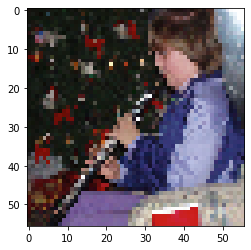

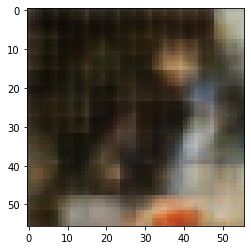

In [5]:
model = tf.keras.models.load_model(output_dir + 'image_data/recons_model')
for x, image in dataset.take(20):
    y = model.predict(x)
    print(y[0])
    plt.imshow(((image[0].numpy()+1)*127.5).astype(int))
    plt.show()
    plt.imshow(((y[0]+1)*127.5).astype(int))
    plt.show()